# LMAPR1492 - Analyse de la structure de bandes électroniques

### Import

In [1]:
# Import
from pymatgen import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.ext.matproj import MPRester as mp
from pymatgen.io.cif import CifWriter
from jupyter_jsmol.pymatgen import quick_view
from pymatgen.electronic_structure import bandstructure
from pymatgen.electronic_structure import plotter
from pymatgen.electronic_structure.core import Spin
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from scipy.optimize import curve_fit

# User APE key
USER_API_KEY = "smdQ36uJeil4SE7H"

### Téléchargement de la structure et du fichier

In [2]:
# Download structure
structure = mp(USER_API_KEY).get_structure_by_material_id("mp-22473")

# Download file
file_writer = CifWriter(structure, 0.1)
file_writer.write_file('NaInSe2-mp-22473.cif')

### Structure conventionnelle

In [3]:
# Visualize conventional structure
conventional_structure = SpacegroupAnalyzer(structure).get_conventional_standard_structure()
view = quick_view(conventional_structure, "packed")
display(view)

JsmolView(layout=Layout(align_self='stretch', height='400px'))

### Téléchargement de la structure de bande

In [4]:
# Download structure band
band_structure = mp(USER_API_KEY).get_bandstructure_by_material_id("mp-22473")

### Recherche de toutes les valeurs importantes pour l'analyse

In [5]:
# Get plot
plot = plotter.BSPlotter(band_structure)

# Get data from plot
data = plot.bs_plot_data()

# Get keys
keys = data.keys()

# Get ticks
# The variable 'ticks' contains the distances of each point forming the path relative to the origin.
ticks = data["ticks"]

# Get distances from data
# The variable 'distances' is a set of arrays each containing the distances from the origin along a given segment path.
distances = data["distances"]

# Get energy
# The variable 'energy' contains the energy band structure for each segment
energy = data["energy"]

# Get CBM (= conductive band minimum)
# The variable 'cbm' contains the coordinates of each minimum
cbm = data["cbm"]

# Get VBM (= valence band maximum)
# The variable 'vbm' contains the coordinates of each maximum
vbm = data["vbm"]

# Get band gap
band_gap = band_structure.get_band_gap()

# Get zero_energy
zero_energy = data["zero_energy"]

### Formatage des données

In [6]:
# Format values to be used
# The variable 'energy_dict' has the following structure :
# - key = index corresponding to the list of distances
# - val = a set of lists corresponding to each energy band

energy_dict = {}   # Store the values here
index = 0          # Index from which to read

# Iterate over all distances
for i in range(len(distances)):
    # Set key
    key = i
    # Initialize an empty list (corresponding to all bands)
    list_energy = []
    # Iterate over all bands
    for j in range(0, len(band_structure.bands[Spin.up])):
        # Initialize an empty list (corresponding to a single band)
        energy = []
        # Iterate over an interval of the band
        for k in range(index, index+len(distances[i])):
            energy.append(band_structure.bands[Spin.up][j][k]-zero_energy)   # Normalize with zero_energy
        list_energy.append(energy)
    # Change offset
    index = index + len(distances[i])
    # Add to main dictionary
    energy_dict[key] = list_energy

### Visualisation de la structure de bandes

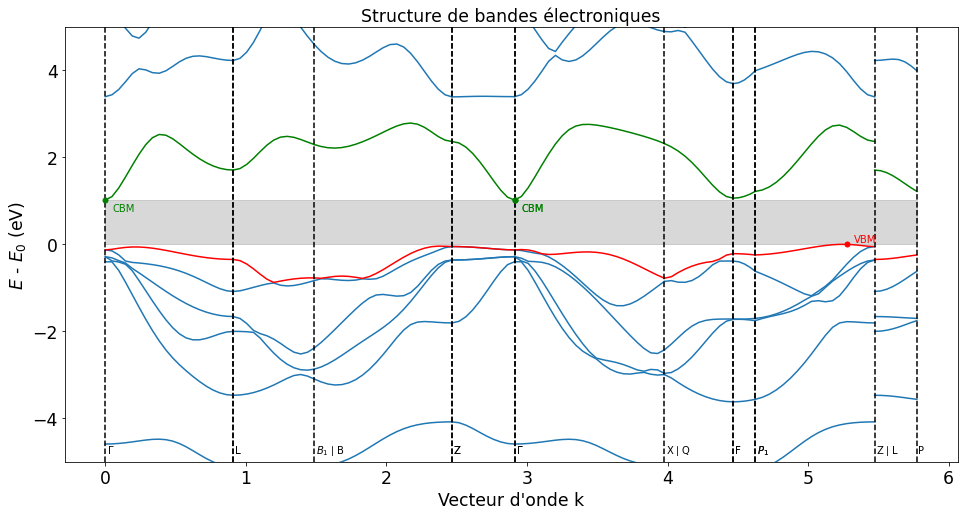

In [7]:
# Set parameters for the plot
params = {#'legend.fontsize': 'xx-large',
          'figure.figsize': (16, 8),
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large',
          'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

# Change values here if you want to limit Y axis range
y_max = 5
y_min = -5

# Change values here to color bands
band_1 = 15
band_2 = 16

# Set a grid
plt.grid(False)

# Plot energy band structure
len_dist = len(distances)
for i in range(0, len_dist):
    len_energy = len(energy_dict[i])
    for j in range(0, len_energy):
        if (j == band_1):
            plt.plot(distances[i], energy_dict[i][j], "red")
        elif (j == band_2):
            plt.plot(distances[i], energy_dict[i][j], "green")
        else:
            plt.plot(distances[i], energy_dict[i][j], "tab:blue")

# Plot labels
x_offset = 0.01
y_offset = 0.2
for i in range(0, len(data["ticks"]["distance"])):
    x = data["ticks"]["distance"][i]
    text = data["ticks"]["label"][i]
    plt.text(x + x_offset, y_min + y_offset, s=text)
    plt.axline([x, 0], [x, 2], color="black", linestyle="dashed")
            
# Plot band gap
x = [distances[0][0], distances[-1][-1]]
y_1 = [vbm[0][1], vbm[0][1]]
y_2 = [cbm[0][1], cbm[0][1]]
plt.fill_between(x, y_1, y_2, color="grey", alpha=0.3)

# Plot VBM
for point in vbm:
    plt.plot(point[0], point[1], "o", markersize=5, color="red")
    plt.text(point[0]+0.05, point[1]+0.05, s="VBM", color="red")
    
# Plot CBM
for point in cbm:
    plt.plot(point[0], point[1], "o", markersize=5, color="green")
    plt.text(point[0]+0.05, point[1]-0.25, s="CBM", color="green")

# Limit Y range
plt.ylim(y_min, y_max)

# Plot
plt.title("Structure de bandes électroniques")
plt.xlabel("Vecteur d'onde k")
plt.ylabel("$E$ - $E_0$ (eV)")
plt.show()

### Analyse de la bande interdite
En observant le graphique ci-dessus on remarque qu'on a bien une bande interdite. L'épaisseur de cette bande est de $1.0193 eV$. Cela correspond à un matériau semi-conducteur. On observe qu'on a deux points particuliers: CBM (= minimum de la bande de conduction) en vert et VBM (= maximum de la bande de valence) en rouge.

Le CBM est situé en $\Gamma$ avec une énergie de $1.0193 eV$ (normalisée par rapport à l'énergie de Fermi).

Le VBM est situé en $5.27$ sur le graphique avec une énergie de $0 eV$ (normalisée par rapport à l'énergie de Fermi).

Le CBM et le VBM ne correspondent pas au même vecteur d'onde. En d'autres mots, ils ne sont pas alignés sur le graphique. On peut conclure que la bande interdite est une bande indirecte.

De plus, on trouve que la dernière bande de valence a pour numéro $15$ et la première bande de conduction a pour numéro $16$.

### Visualisation de la dispersion

In [8]:
# Compute dispersion function
def compute_dispersion(d, energy_dict):
    result_v = {}
    result_c = {}
    length_dist = len(d)
    for i in range(0, length_dist):   # Format: [[x_1, y_1], [x_2, y_2], dispersion_value]  
        # Compute points
        point_v_1 = [d[i][0], energy_dict[i][15][0]]
        point_v_2 = [d[i][-1], energy_dict[i][15][-1]]
        point_c_1 = [d[i][0], energy_dict[i][16][0]]
        point_c_2 = [d[i][-1], energy_dict[i][16][-1]]
        # Compute dispersion
        disp_v = (point_v_2[1]-point_v_1[1])/(point_v_2[0]-point_v_1[0])
        disp_c = (point_c_2[1]-point_c_1[1])/(point_c_2[0]-point_c_1[0])
        # Set values
        result_v[i] = [point_v_1, point_v_2, disp_v]
        result_c[i] = [point_c_1, point_c_2, disp_c]
    # Return statement
    return result_v, result_c

In [9]:
# Compute values
result_v, result_c = compute_dispersion(distances, energy_dict)

# Print values
print("Valence band")
for i in result_c:
    print(i,"|", result_v[i][2])
print("Conduction band")
for i in result_c:
    print(i, "|", result_c[i][2])

# Set values of min/max indexes (checkpoint)
v = (3, 5)
c = (2, 3)

Valence band
0 | -0.24102845737032932
1 | -0.7380758887339464
2 | 0.7350546422530252
3 | -0.17309052361864016
4 | -0.6101592321495477
5 | 1.1494214615775598
6 | -0.19275967925147763
7 | 0.22787612433311227
8 | 0.34233733542770894
Conduction band
0 | 0.7567964137568614
1 | 1.0221116876485152
2 | 0.07013140949522732
3 | -3.0257122700089587
4 | 1.219567845529728
5 | -2.563262865628709
6 | 0.9983798669536684
7 | 1.350778100644006
8 | -1.6328393025065073


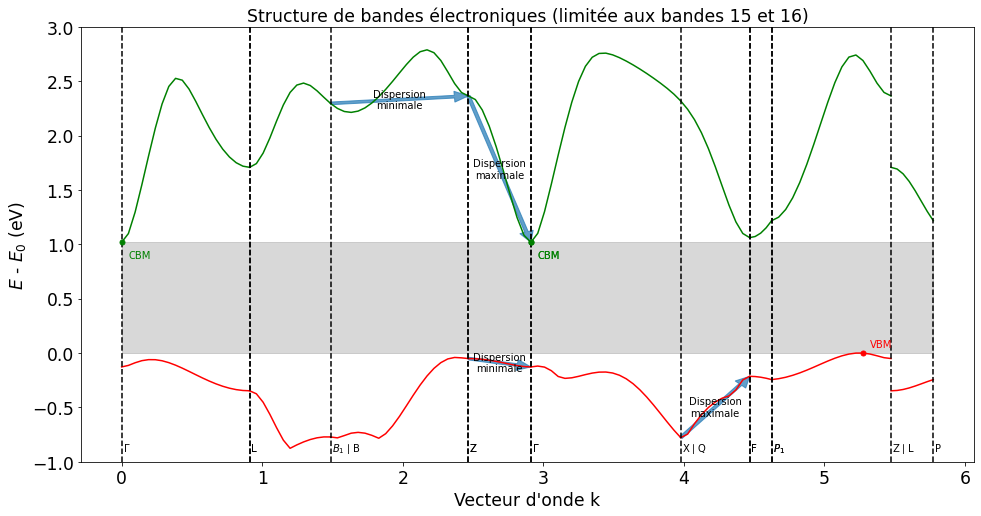

In [10]:
# Change values here if you want to limit Y axis range
y_max = 3
y_min = -1

# Plot energy band structure
len_dist = len(distances)
for i in range(0, len_dist):
    plt.plot(distances[i], energy_dict[i][band_1], "red")
    plt.plot(distances[i], energy_dict[i][band_2], "green")

# Plot labels
x_offset = 0.01
y_offset = 0.1
for i in range(0, len(data["ticks"]["distance"])):
    x = data["ticks"]["distance"][i]
    text = data["ticks"]["label"][i]
    plt.text(x + x_offset, y_min + y_offset, s=text)
    plt.axline([x, 0], [x, 2], color="black", linestyle="dashed")
            
# Plot band gap
x = [distances[0][0], distances[-1][-1]]
y_1 = [vbm[0][1], vbm[0][1]]
y_2 = [cbm[0][1], cbm[0][1]]
plt.fill_between(x, y_1, y_2, color="grey", alpha=0.3)

# Plot VBM
for point in vbm:
    plt.plot(point[0], point[1], "o", markersize=5, color="red")
    plt.text(point[0]+0.05, point[1]+0.05, s="VBM", color="red")
    
# Plot CBM
for point in cbm:
    plt.plot(point[0], point[1], "o", markersize=5, color="green")
    plt.text(point[0]+0.05, point[1]-0.15, s="CBM", color="green")

# Plot dispersion arrows
counter = 0
for i in v:
    x = result_v[i][0][0]
    y = result_v[i][0][1]
    dx = result_v[i][1][0] - result_v[i][0][0]
    dy = result_v[i][1][1] - result_v[i][0][1]
    plt.arrow(x, y, dx, dy, width=0.025, length_includes_head=True, color="tab:blue", head_width=0.1, head_length=0.1, overhang=0, alpha=0.7)    
    if (counter == 0): plt.text(x+dx/2, y+dy/2, horizontalalignment="center", verticalalignment="center", s="Dispersion\nminimale")
    elif (counter == 1): plt.text(x+dx/2, y+dy/2, horizontalalignment="center", verticalalignment="center", s="Dispersion\nmaximale")
    counter = counter + 1

counter = 0
for i in c:
    x = result_c[i][0][0]
    y = result_c[i][0][1]
    dx = result_c[i][1][0] - result_c[i][0][0]
    dy = result_c[i][1][1] - result_c[i][0][1]
    plt.arrow(x, y, dx, dy, width=0.025, length_includes_head=True, color="tab:blue", head_width=0.1, head_length=0.1, overhang=0, alpha=0.7)    
    if (counter == 0): plt.text(x+dx/2, y+dy/2, horizontalalignment="center", verticalalignment="center", s="Dispersion\nminimale")
    elif (counter == 1): plt.text(x+dx/2, y+dy/2, horizontalalignment="center", verticalalignment="center", s="Dispersion\nmaximale")
    counter = counter + 1

# Limit Y range
plt.ylim(y_min, y_max)

# Plot
plt.title("Structure de bandes électroniques (limitée aux bandes 15 et 16)")
plt.xlabel("Vecteur d'onde k")
plt.ylabel("$E$ - $E_0$ (eV)")
plt.show()

### Analyse de la dispersion

La notion de dispersion peut être caractérisée comme étant une dépendance de l'énergie par rapport au vecteur d'onde $\textbf{k}$. Si on a une courbe constante, on dit que la dispersion est faible. A l'inverse, si on a une forte variation de l'énergie, on a une grande dispersion.
La dispersion est calculée sur un segment du parcours (par exemple: $B_1\mid B$ et $Z$). En effet, elle est associée à la largeur de bande et n'est pas une grandeur locale dans l'espace réciproque.  
C'est pourquoi, on utilise la formule : $$ \text{coefficient de dispersion} = \frac{\Delta Y}{\Delta X} $$  
La dernière bande de valence présente le plus de dispersion entre $X \mid Q$ et $F$ et le moins de dispersion entre $Z$ et $\Gamma$.  
La premère bande de conduction présente le plus de dispersion entre $Z$ et $\Gamma$. et le moins de dispersion entre $B_1 \mid B$ et $Z$.

### Visualisation des approximations paraboliques

VBM : -1.802 k² + 18.919 k + -49.662
CBM : 30.606 k² + -178.031 k + 259.915


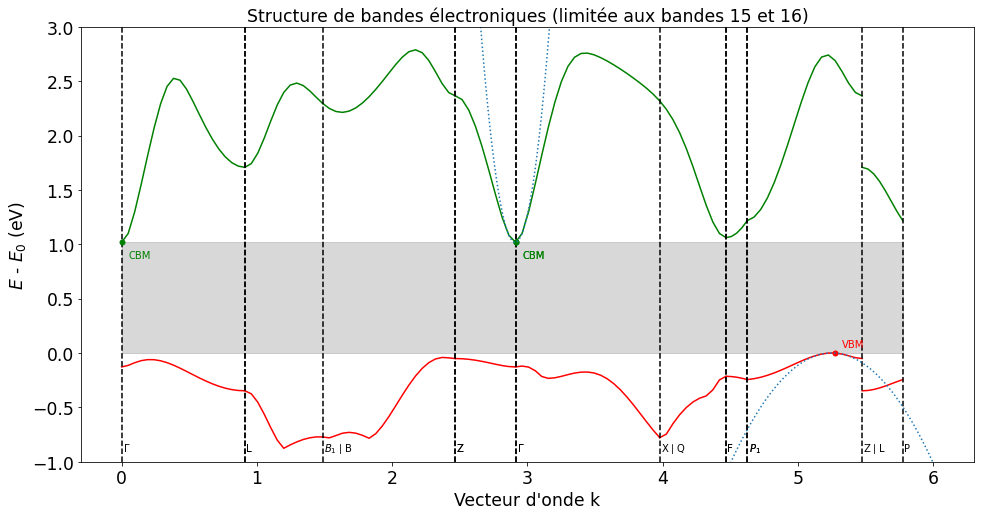

In [11]:
# Change values here if you want to limit Y axis range
y_max = 3
y_min = -1

# Plot energy band structure
len_dist = len(distances)
for i in range(0, len_dist):
    plt.plot(distances[i], energy_dict[i][band_1], "red")
    plt.plot(distances[i], energy_dict[i][band_2], "green")

# Plot labels
x_offset = 0.01
y_offset = 0.1
for i in range(0, len(data["ticks"]["distance"])):
    x = data["ticks"]["distance"][i]
    text = data["ticks"]["label"][i]
    plt.text(x + x_offset, y_min + y_offset, s=text)
    plt.axline([x, 0], [x, 2], color="black", linestyle="dashed")
            
# Plot band gap
x = [distances[0][0], distances[-1][-1]]
y_1 = [vbm[0][1], vbm[0][1]]
y_2 = [cbm[0][1], cbm[0][1]]
plt.fill_between(x, y_1, y_2, color="grey", alpha=0.3)

# Plot VBM
for point in vbm:
    plt.plot(point[0], point[1], "o", markersize=5, color="red")
    plt.text(point[0]+0.05, point[1]+0.05, s="VBM", color="red")
    
# Plot CBM
for point in cbm:
    plt.plot(point[0], point[1], "o", markersize=5, color="green")
    plt.text(point[0]+0.05, point[1]-0.15, s="CBM", color="green")

# CBM parabolic approximation
k_cbm = [distances[3][-2], cbm[1][0], distances[4][1]]
e_cbm = [energy_dict[3][band_2][-2], cbm[1][1], energy_dict[4][band_2][1]]
approx_cbm = np.polyfit(k_cbm, e_cbm, 2)
x_cbm = np.linspace(2.5, 3.5, 1000)
y_cbm = np.polyval(approx_cbm, x_cbm)

# VBM parabolic approximation
k_vbm = [distances[7][12], vbm[0][0], distances[7][14]]
e_vbm = [energy_dict[7][band_1][12], vbm[0][1], energy_dict[7][band_1][14]]
approx_vbm = np.polyfit(k_vbm, e_vbm, 2)
x_vbm = np.linspace(4.5, 6, 1000)
y_vbm = np.polyval(approx_vbm, x_vbm)

# Plot
plt.plot(x_cbm, y_cbm, color="tab:blue", linestyle="dotted")
plt.plot(x_vbm, y_vbm, color="tab:blue", linestyle="dotted")

# Print polynomial expressions
print("VBM :", np.round(approx_vbm[0], 3), "k² +", np.round(approx_vbm[1], 3), "k +", np.round(approx_vbm[2], 3))
print("CBM :", np.round(approx_cbm[0], 3), "k² +", np.round(approx_cbm[1], 3), "k +", np.round(approx_cbm[2], 3))

# Limit Y range
plt.ylim(y_min, y_max)

# Plot
plt.title("Structure de bandes électroniques (limitée aux bandes 15 et 16)")
plt.xlabel("Vecteur d'onde k")
plt.ylabel("$E$ - $E_0$ (eV)")
plt.show()

### Détermination de la masse effective

Dans la partie "Les électrons dans le cristal" du cours (slide 43), nous avons la formule suivante: $$m_{ij}^{*} = \left(\frac{\partial^2 E}{\partial k_i \partial k_j}\right)^{-1} $$  
Nous avons besoin de la dérivée seconde de l'énergie en fonction de $k$.  
Pour la bande de valence, la dérivée seconde vaut $-3.602$. En prenant la valeur absolue et en inversant, on obtient: $0.277$. En multipliant par la masse de l'électron $9.11 \times 10^{-31} kg$, on obtient $2.528 \times 10^{-31} kg$.  
Pour la bande de conduction, la dérivée seconde vaut $61.212$. En prenant la valeur absolue et en inversant, on obtient: $0.016$. En multipliant par la masse de l'électron $9.11 \times 10^{-31} kg$, on obtient $1.488 \times 10^{-32} kg$.

### Ressources
http://matgenb.materialsvirtuallab.org/2017/09/03/Analyze-and-plot-band-structures.html  
http://matgenb.materialsvirtuallab.org/

### Quelques tests de code intéressants

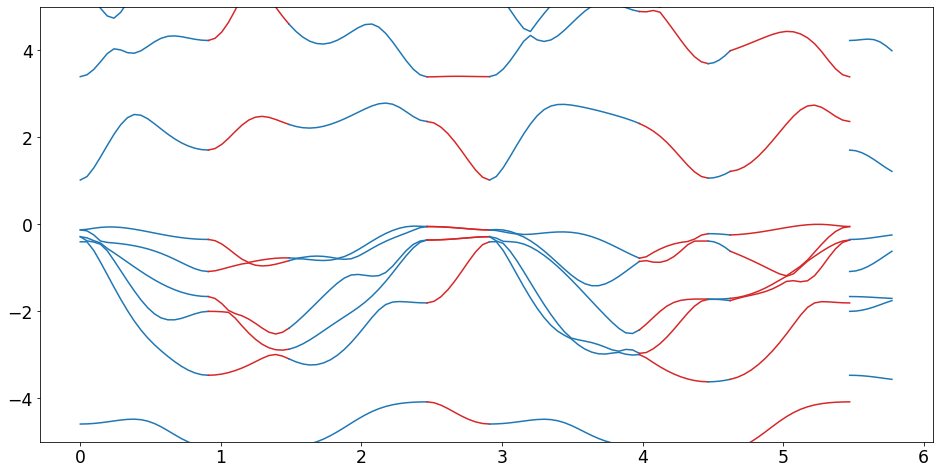

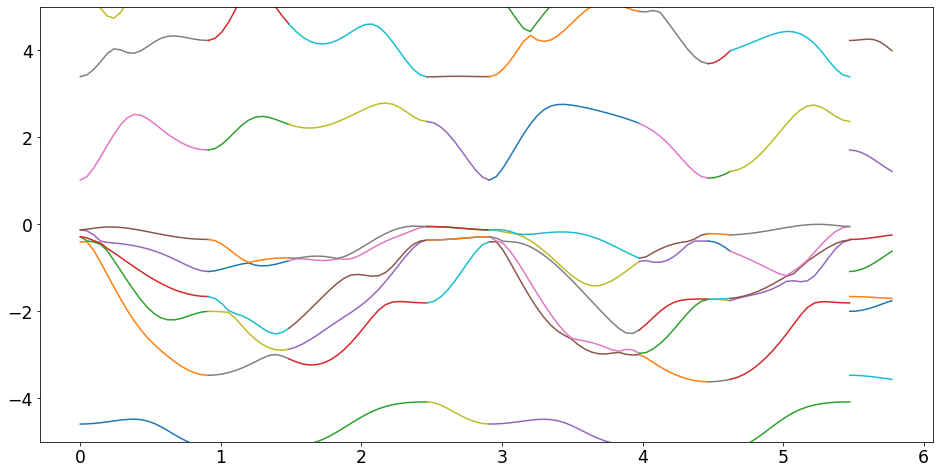

In [12]:
# TESTS
for i in range(len(distances)):
    for j in range(0, len(energy_dict[i])):
        if (i%2==0): plt.plot(distances[i], energy_dict[i][j], color="tab:blue")
        else: plt.plot(distances[i], energy_dict[i][j], color="tab:red")
plt.ylim(-5, 5)
plt.show()

for i in range(len(distances)):
    for j in range(0, len(energy_dict[i])):
        plt.plot(distances[i], energy_dict[i][j])
plt.ylim(-5, 5)
plt.show()

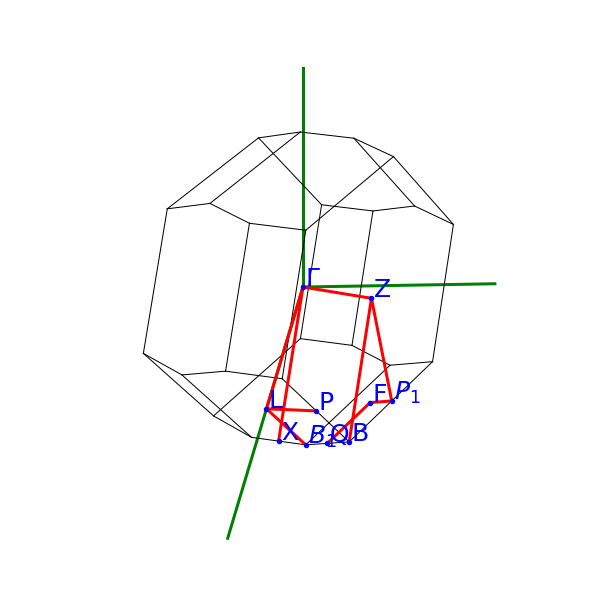

In [13]:
plot.plot_brillouin()